In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import  preprocessing
from sklearn.metrics import log_loss
from sklearn.cross_validation import KFold,StratifiedKFold
#import matplotlib.pyplot as plt

/opt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from mochi import *
import pickle

In [ ]:
import datetime

In [19]:
#try xgboost
#original fucntion from SRK
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None,      seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,     max_depth = 6,cv_dict = None,verbose_eval=True):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = eta
    param['max_depth'] = max_depth
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.3
    param['seed'] = seed_val
    param['nthread'] = 2
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y,feature_names=feature_names)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y,feature_names=feature_names)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,        early_stopping_rounds=early_stop,evals_result = cv_dict,verbose_eval = verbose_eval)
    else:
        xgtest = xgb.DMatrix(test_X,feature_names=feature_names)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [4]:
#lodaing data
data_path = "/home/raku/kaggleData/2sigma/"
train_file = data_path + "train_t.json"
test_file = data_path + "test_t.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)
"""
pic_file = data_path + "listing_image_time.csv"
pic_df = pd.read_csv(pic_file).set_index('Listing_Id')

train_df=train_df.join(pic_df,on='listing_id',how='left')
test_df=test_df.join(pic_df,on='listing_id',how='left')

train_df.to_json(data_path + "train_t.json")
test_df.to_json(data_path + "test_t.json")
"""

(49352, 16)
(74659, 15)


'\npic_file = data_path + "listing_image_time.csv"\npic_df = pd.read_csv(pic_file).set_index(\'Listing_Id\')\n\ntrain_df=train_df.join(pic_df,on=\'listing_id\',how=\'left\')\ntest_df=test_df.join(pic_df,on=\'listing_id\',how=\'left\')\n\ntrain_df.to_json(data_path + "train_t.json")\ntest_df.to_json(data_path + "test_t.json")\n'

In [5]:
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price",'time_stamp']

In [7]:
# In[6]:

#some transfromed features
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

#some new numerical features related to the price
train_df["price_per_bath"] =  (train_df["price"]*1.0/train_df["bathrooms"]).replace(np.Inf,-1)
train_df["price_per_bed"] = (train_df["price"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["bath_per_bed"] = (train_df["bathrooms"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["price_per_room"] = (train_df["price"]*1.0/(train_df["bedrooms"]+train_df["bathrooms"])).replace(np.Inf,-1)

test_df["price_per_bath"] =  (test_df["price"]*1.0/test_df["bathrooms"]).replace(np.Inf,-1)
test_df["price_per_bed"] = (test_df["price"]*1.0/test_df["bedrooms"]).replace(np.Inf,-1)
test_df["bath_per_bed"] = (test_df["bathrooms"]*1.0/test_df["bedrooms"]).replace(np.Inf,-1)
test_df["price_per_room"] = (test_df["price"]*1.0/(test_df["bedrooms"]+test_df["bathrooms"])).replace(np.Inf,-1)


# adding all these new features to use list # "listing_id",
features_to_use.extend(["num_photos", "num_features", "num_description_words",                        "created_year","listing_id", "created_month", "created_day", "created_hour"])
#price new features
features_to_use.extend(["price_per_bed","bath_per_bed","price_per_room"])

#for latter use
train_df["dayofyear"] = train_df["created"].dt.dayofyear
test_df["dayofyear"] = test_df["created"].dt.dayofyear

train_df['house_type']=map(lambda x,y:(x,y),train_df['bedrooms'],train_df['bathrooms'])
train_df['house_type'] = train_df['house_type'].apply(str)
test_df['house_type']=map(lambda x,y:(x,y),test_df['bedrooms'],test_df['bathrooms'])
test_df['house_type'] = test_df['house_type'].apply(str)

In [8]:
"""
new categorical data generated from the old ones
"""
#new feature for the street_address, use them instead of the original one
train_df["street_name"] = train_df["street_address"].apply(proecessStreet)
test_df["street_name"] = test_df["street_address"].apply(proecessStreet)

train_df['building0']=map(lambda x:1 if x== '0' else 0,train_df['building_id'])
test_df['building0']=map(lambda x:1 if x== '0' else 0,test_df['building_id'])

In [9]:
# In[10]:

#dealing with features

#preprocessing for features
train_df["features"] = train_df["features"].apply(lambda x:["_".join(i.split(" ")).lower().strip().replace('-','_')                                                             for i in x])
test_df["features"] = test_df["features"].apply(lambda x:["_".join(i.split(" ")).lower().strip().replace('-','_')                                                         for i in x])
#create the accept list
accept_list = list(featureList(train_df,test_df,limit = 0.001))

#map the feature to dummy slots
featureMapping(train_df,test_df,accept_list)
features_to_use.extend(map(lambda x : 'with_'+x,accept_list))

In [10]:
# In[16]:

#the basic features from preprocessing 
features = list(set(features_to_use))

#features to be added during cv by cv-manner statistics
features.extend(['manager_id_perf'])
features.extend(['m3perf','m7perf','m14perf','m30perf'])
features.extend(['m3perf_f','m7perf_f','m14perf_f','m30perf_f'])
features.extend(['manager_id_nrank'])


#categorical features to be added
categorical = ["display_address", "street_address","street_name",'building_id','manager_id','building0','house_type']
features.extend(categorical)
features.extend(['cluster_id_10','cluster_id_30'])


#statistical features
features.extend(['m_m_distance','mlon','mlat'])

main_st_nf = ["bathrooms", "bedrooms","price_per_bed","bath_per_bed","price_per_room","num_photos", "num_features", "num_description_words",'price']
main_statistics =['mean','max','min','median']

for st in main_statistics:
    features.extend(map(lambda x : 'manager_id_'+x+'_'+st,main_st_nf))
    features.extend(map(lambda x : 'house_type_'+x+'_'+st,main_st_nf)) 

features.extend(map(lambda x : 'cluster_id_10_'+x+'_'+'mean',main_st_nf))
features.extend(map(lambda x : 'cluster_id_30_'+x+'_'+'mean',main_st_nf))

price_related = ['price_per_bed','price_per_room','price']

features.extend(['manager_id_size','house_type_size'])

In [11]:
features=list(set(features))

processMap(train_df)
processMap(test_df)
train_df = train_df.fillna(-1)
test_df=test_df.fillna(-1)
getCluster(train_df,test_df,30)
getCluster(train_df,test_df,10)

In [14]:
#K-FOLD evaluation for the statistic features
skf=KFold(len(train_df['interest_level']),5,shuffle=True,random_state = 42)
#dev set adding manager skill
for train,test in skf:
        performance_eval(train_df.iloc[train,:],train_df.iloc[test,:],feature='manager_id',
                       update_df = train_df,smoothing=False)
        temporalManagerPerf_f(train_df.iloc[train,:],train_df.iloc[test,:],update_df = train_df)
                
performance_eval(train_df,test_df,feature='manager_id',smoothing=False)
temporalManagerPerf_f(train_df,test_df)
    
    
#statitstic
for f in main_st_nf:
    #print f
    categorical_statistics(train_df,test_df,'manager_id',f)
    categorical_statistics(train_df,test_df,'cluster_id_10',f)
    categorical_statistics(train_df,test_df,'cluster_id_30',f)
    categorical_statistics(train_df,test_df,'house_type',f)
    categorical_size(train_df,test_df,'manager_id')
    categorical_size(train_df,test_df,'house_type')


#manager main location
manager_lon_lat(train_df,test_df)

for f in categorical:

    if train_df[f].dtype=='object':
        #print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f])+list(test_df[f]))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [15]:
train_df = train_df.fillna(-1)
test_df = test_df.fillna(-1)

store = '/home/raku/kaggleData/2sigma/xgb142/'

train_df.to_json(store+'xgb1.42-train.json')
test_df.to_json(store+'xgb1.42-test.json')

pickl_file = store+'xgb142features.pickle'
fileObject = open(pickl_file,'wb') 
pickle.dump(features,fileObject)   
fileObject.close()

In [40]:
# In[17]:

#running and getting the cv from xgboost
target_num_map = {'high':0, 'medium':1, 'low':2}

train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

KF=StratifiedKFold(train_y,5,shuffle=True,random_state = 2333)

cv_scores = []
cv_result = []
models = []

i=0
for dev_index, val_index in KF: 
    result_dict = {}
    
    dev_set, val_set = train_df.iloc[dev_index,:] , train_df.iloc[val_index,:] 
    """
    #=============================================================        
    #feature engineerings for the categorical features
    #fill substitute the small size values by their mean
    for f in ['display_address','manager_id','building_id','street_name']:
        dev_set,val_set  = singleValueConvert(dev_set,val_set,f,1)
    
    #kmeans grouping
    getCluster(dev_set,val_set,30)
    getCluster(dev_set,val_set,10)
    

    #K-FOLD evaluation for the statistic features
    skf=KFold(len(dev_set['interest_level']),5,shuffle=True,random_state = 42)
    #dev set adding manager skill
    for train,test in skf:
            performance_eval(dev_set.iloc[train,:],dev_set.iloc[test,:],feature='manager_id',k=5,g=10,
                           update_df = dev_set,smoothing=False)
            temporalManagerPerf_f(dev_set.iloc[train,:],dev_set.iloc[test,:],update_df = dev_set)


    performance_eval(dev_set,val_set,feature='manager_id',k=5,g=10,smoothing=False)
    temporalManagerPerf_f(dev_set,val_set)
        
        
    #statitstic
    for f in main_st_nf:
        #print f
        categorical_statistics(dev_set,val_set,'manager_id',f)
        categorical_statistics(dev_set,val_set,'cluster_id_10',f)
        categorical_statistics(dev_set,val_set,'cluster_id_30',f)
        categorical_statistics(dev_set,val_set,'house_type',f)
        categorical_size(dev_set,val_set,'manager_id')
        categorical_size(dev_set,val_set,'house_type')
    
    #for f in price_related:
    #    rank_on_categorical(dev_set,val_set,'house_type_30',f,random =None)

    
    #manager main location
    manager_lon_lat(dev_set,val_set)
    
    for f in categorical:
    
        if dev_set[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(dev_set[f])+list(val_set[f]))
            dev_set[f] = lbl.transform(list(dev_set[f].values))
            val_set[f] = lbl.transform(list(val_set[f].values))
    
    #============================================================
    #dev_set.to_csv('having_view.csv',index=False,encoding  = 'utf-8')
    
    """
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    
    """
    runXGB(dev_X, train_y, val_X, test_y=None, feature_names=None, \
    seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1, max_depth = 6)
    """        
    
    preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=features,\
           early_stop = 64,num_rounds=4500,eta = 0.1,max_depth=4,cv_dict = result_dict,verbose_eval=100)

    loss = log_loss(val_y, preds)
    
    """
    #save the pickles for futures use
    pickl_file = store+'xgb142-5fold-out'+str(i)+'.pickle'
    fileObject = open(pickl_file,'wb') 
    pickle.dump(preds,fileObject)   
    fileObject.close()
    """
    
    cv_scores.append(loss)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print 'loss for the turn '+str(i)+' is '+str(loss)
    break

[0]	train-mlogloss:1.03691	test-mlogloss:1.03782
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 64 rounds.
[100]	train-mlogloss:0.51431	test-mlogloss:0.550616
[200]	train-mlogloss:0.470358	test-mlogloss:0.530696
[300]	train-mlogloss:0.440814	test-mlogloss:0.524611
[400]	train-mlogloss:0.41679	test-mlogloss:0.521665
[500]	train-mlogloss:0.396991	test-mlogloss:0.520391
[600]	train-mlogloss:0.378263	test-mlogloss:0.520061
Stopping. Best iteration:
[553]	train-mlogloss:0.386797	test-mlogloss:0.51984

loss for the turn 1 is 0.51988604158


In [ ]:
print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

cvResult = CVstatistics(cv_result,'mlogloss')

meanTestError = cvResult.result.filter(like='test').mean(axis=1)

print meanTestError[meanTestError==np.min(meanTestError)]

In [30]:
import datetime
timestamp =1478091590 
value = datetime.datetime.fromtimestamp(timestamp)
print(value.strftime('%Y-%m-%d %H:%M:%S'))

2016-11-02 20:59:50


In [39]:
'time_stamp' in features

True

In [32]:
train_df['pic_date']=train_df['time_stamp'].apply(lambda x : datetime.datetime.fromtimestamp(x))

In [41]:
import matplotlib.pyplot as plt

In [43]:
import seaborn as sns

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


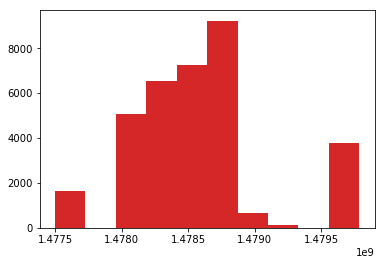

In [48]:
plt.hist(train_df.loc[train_df['interest_level']=='low','time_stamp'])
plt.show()

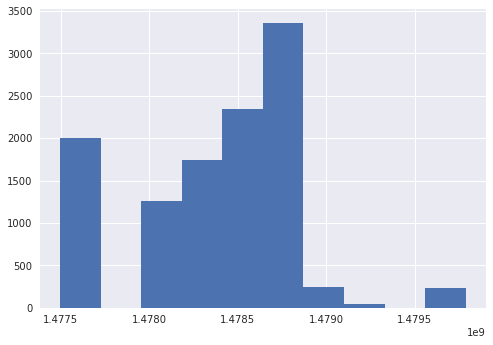

In [49]:
plt.hist(train_df.loc[train_df['interest_level']=='medium','time_stamp'])
plt.show()

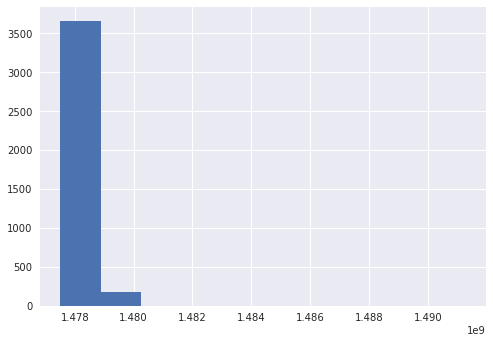

In [50]:
plt.hist(train_df.loc[train_df['interest_level']=='high','time_stamp'])
plt.show()